In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from datasets.basic_clmn_dataset import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle

In [17]:
config_file_path = '{}/configs/boardgames_ranking_experiment.yaml'.format(root_path)

with open(config_file_path,'r') as conf_file:
    conf = yaml.full_load(conf_file)
    conf['project_root'] = root_path 

data_conf = conf['data_conf']
weak_sup_conf = conf['weak_sup_conf'] # For partial ranking experiments, we should give
l2r_training_conf = conf['l2r_training_conf']
data_conf['project_root'] = root_path

In [3]:
dataset= datasets_factory.create_dataset(data_conf)
dataset.create_samples()

Generate samples...


In [18]:
weak_sup_methods = ['weighted_kemeny', 'weighted_kemeny_TDDK']
weak_sup_conf['seed'] = 1
l2r_training_conf['epochs'] = 20
results = {}
final_results = {}
Visualize = False

for number_of_LFs in range(3,11):
    
    weak_sup_conf['num_LFs'] = number_of_LFs
    final_results[str(number_of_LFs)] = {}
    
    print("#######################################################################")
    print("################### Number of LFs = ", number_of_LFs)
    print("#######################################################################")
    
    for weak_sup_method in weak_sup_methods:
        
        weak_sup_conf['inference_rule'] = weak_sup_method
        
        print("Calculating for: ", weak_sup_method)
    
    
        if l2r_training_conf['use_weak_labels']:
            Y_tilde, thetas, individual_kt = get_weak_labels(dataset, weak_sup_conf, root_path=root_path)
            r_utils = RankingUtils(data_conf['dimension'])
            kt = r_utils.mean_kt_distance(Y_tilde,dataset.Y)
            print('Label model kt distance: ', kt)
            dataset.set_Y_tilde(Y_tilde)
        else:
            kt = None

        print("$$$$$$ Thetas = ", thetas)
        ptwrapper = PtrankingWrapper(data_conf=data_conf, weak_sup_conf=weak_sup_conf,
                                     l2r_training_conf=l2r_training_conf, result_path=conf['results_path'],
                                     wl_kt_distance = kt)
        X_train, X_test, Y_train, Y_test = dataset.get_train_test_torch(use_weak_labels=l2r_training_conf['use_weak_labels'])
        ptwrapper.set_data(X_train=X_train, X_test=X_test,
                          Y_train=Y_train, Y_test=Y_test)
        model = ptwrapper.get_model()

        results[weak_sup_method] = ptwrapper.train_model(model, verbose=0)
        
        final_results[str(number_of_LFs)][weak_sup_method] = results[weak_sup_method]
        
        # TDDK_results = ptwrapper.train_model(model, verbose=1)
        
    if Visualize: 

        plt.rcParams['font.size'] = '24'

        normal_losses = results['weighted_kemeny']['loss']
        normal_train_tau = results['weighted_kemeny']['train_tau']
        normal_test_tau = results['weighted_kemeny']['test_tau']
        normal_train_ndcg1 = results['weighted_kemeny']['train_ndcg1']
        normal_train_ndcg3 = results['weighted_kemeny']['train_ndcg3']
        normal_train_ndcg5 = results['weighted_kemeny']['train_ndcg5']
        normal_test_ndcg1 = results['weighted_kemeny']['test_ndcg1']
        normal_test_ndcg3 = results['weighted_kemeny']['test_ndcg3']
        normal_test_ndcg5 = results['weighted_kemeny']['test_ndcg5']

        TDDK_losses = results['weighted_kemeny_TDDK']['loss']
        TDDK_train_tau = results['weighted_kemeny_TDDK']['train_tau']
        TDDK_test_tau = results['weighted_kemeny_TDDK']['test_tau']
        TDDK_train_ndcg1 = results['weighted_kemeny_TDDK']['train_ndcg1']
        TDDK_train_ndcg3 = results['weighted_kemeny_TDDK']['train_ndcg3']
        TDDK_train_ndcg5 = results['weighted_kemeny_TDDK']['train_ndcg5']
        TDDK_test_ndcg1 = results['weighted_kemeny_TDDK']['test_ndcg1']
        TDDK_test_ndcg3 = results['weighted_kemeny_TDDK']['test_ndcg3']
        TDDK_test_ndcg5 = results['weighted_kemeny_TDDK']['test_ndcg5']


        fig, axes = plt.subplots(ncols=2, figsize=(16,9))
        axes[0].plot(normal_losses, label='normal_loss')
        axes[0].set_title(f'Training loss', fontsize=22)
        axes[0].plot(TDDK_losses, label='TDDK_loss')
        axes[0].set_title(f'Training loss', fontsize=22)
        axes[0].legend(fontsize=10)
        axes[1].plot(normal_train_tau, label='normal_train_mean_kt')
        axes[1].plot(normal_test_tau, label='normal_test_mean_kt')
        axes[1].plot(TDDK_train_tau, label='TDDK_train_mean_kt')
        axes[1].plot(TDDK_test_tau, label='TDDK_test_mean_kt')
        axes[1].set_ylim(0,1)
        axes[1].legend(fontsize=10)
        axes[1].set_title(f'Kendall Tau', fontsize=22)
        plt.show()

        fig, axes = plt.subplots(ncols=2, figsize=(16,9))
        axes[0].plot(normal_train_ndcg1, label='normal_NDCG@1')
        axes[0].plot(normal_train_ndcg3, label='normal_NDCG@3')
        axes[0].plot(normal_train_ndcg5, label='normal_NDCG@5')
        axes[0].plot(TDDK_train_ndcg1, label='TDDK_NDCG@1')
        axes[0].plot(TDDK_train_ndcg3, label='TDDK_NDCG@3')
        axes[0].plot(TDDK_train_ndcg5, label='TDDK_NDCG@5')
        axes[0].legend(fontsize=10)
        axes[0].set_title(f'Train NDCG', fontsize=22)
        axes[1].plot(normal_test_ndcg1, label='normal_NDCG@1')
        axes[1].plot(normal_test_ndcg3, label='normal_NDCG@3')
        axes[1].plot(normal_test_ndcg5, label='normal_NDCG@5')
        axes[1].plot(TDDK_test_ndcg1, label='TDDK_NDCG@1')
        axes[1].plot(TDDK_test_ndcg3, label='TDDK_NDCG@3')
        axes[1].plot(TDDK_test_ndcg5, label='TDDK_NDCG@5')
        axes[1].set_title(f'Test NDCG', fontsize=22)
        axes[1].legend(fontsize=10)
        plt.show()
        
    

#######################################################################
################### Number of LFs =  3
#######################################################################
Calculating for:  weighted_kemeny
^^^^^^^^^^^^^^^^^^^^^Synthetic^^^^^^^^^^^^^^^^^^^^^^
0.2 1.0
0.001 0.01
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use our weak supervision...train_method: triplet_opt,inference_rule: weighted_kemeny
Label model kt distance:  0.3941333333333334
$$$$$$ Thetas =  [0.66975557 0.69848213 0.68128889]
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort

Sequential(
  (FeatureBN): BatchNorm1d(14, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (L_1): Linear(in_features=14, out_features=30, bias=True)
  (BN_1): BatchNorm1d(30, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (ACT_1): ReLU()
  (DR_2): Dropout(p=0.01, inplace=False)
  (L_2): Linear(in_features=30, out_features=30, bias=True)
  (BN_2): BatchNorm1d(30, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (ACT_2): ReLU()
  (L_3): Linear(in_features=30, out_features=1, bias=True)
)
The experiment result is saved in ../../tmp/results/boardgames/default/result_summary.pkl
#######################################################################
################### Number of LFs =  5
#######################################################################
Calculating for:  weighted_kemeny
^^^^^^^^^^^^^^^^^^^^^Synthetic^^^^^^^^^^^^^^^^^^^^^^
0.2 1.0
0.001 0.01
Weak labels generated and saved in ../../data/boardgames/processed/defaul

data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'label_type': <LABEL_TYPE.Permutation: 2>, 'max_rele_level': None, 'fold_num': 1}
Sequential(
  (FeatureBN): BatchNorm1d(14, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (L_1): Linear(in_features=14, out_features=30, bias=True)
  (BN_1): BatchNorm1d(30, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (ACT_1): ReLU()
  (DR_2): Dropout(p=0.01, inplace=False)
  (L_2): Linear(in_features=30, out_features=30, bias=True)
  (BN_2): BatchNorm1d(30, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (ACT_2): ReLU()
  (L_3): Linear

The experiment result is saved in ../../tmp/results/boardgames/default/result_summary.pkl
Calculating for:  weighted_kemeny_TDDK
^^^^^^^^^^^^^^^^^^^^^Synthetic^^^^^^^^^^^^^^^^^^^^^^
0.2 1.0
0.001 0.01
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use our weak supervision...train_method: triplet_opt,inference_rule: weighted_kemeny_TDDK
Label model kt distance:  0.39919999999999994
$$$$$$ Thetas =  [ 0.64776409  0.69992851 10.          0.69559575  0.69487547  0.65166461
  0.69128195 10.        ]
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_pre

data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'label_type': <LABEL_TYPE.Permutation: 2>, 'max_rele_level': None, 'fold_num': 1}
Sequential(
  (FeatureBN): BatchNorm1d(14, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (L_1): Linear(in_features=14, out_features=30, bias=True)
  (BN_1): BatchNorm1d(30, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (ACT_1): ReLU()
  (DR_2): Dropout(p=0.01, inplace=False)
  (L_2): Linear(in_features=30, out_features=30, bias=True)
  (BN_2): BatchNorm1d(30, eps=1e-05, momentum=1.0, affine=True, track_running_stats=False)
  (ACT_2): ReLU()
  (L_3): Linear

In [7]:
final_results


{'3': {'weighted_kemeny': {'loss': [array([498.27542], dtype=float32),
    array([476.8709], dtype=float32),
    array([471.9902], dtype=float32),
    array([468.4723], dtype=float32),
    array([465.66373], dtype=float32),
    array([463.63116], dtype=float32),
    array([460.5647], dtype=float32),
    array([458.73938], dtype=float32)],
   'train_tau': array([[0.43400002],
          [0.412     ],
          [0.3978    ],
          [0.3932    ],
          [0.38340002],
          [0.3746    ],
          [0.37340003],
          [0.3656    ]], dtype=float32),
   'test_tau': array([[0.5111],
          [0.5011],
          [0.5178],
          [0.5169],
          [0.5174],
          [0.5064],
          [0.508 ],
          [0.5103]], dtype=float32),
   'train_ndcg1': [tensor([0.5825]),
    tensor([0.6140]),
    tensor([0.6410]),
    tensor([0.6525]),
    tensor([0.6570]),
    tensor([0.6670]),
    tensor([0.6630]),
    tensor([0.6750])],
   'train_ndcg3': [tensor([0.6805]),
    tensor([0.6979]

#######################################################################
################### Number of LFs =  3
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.3494666666666667
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'label

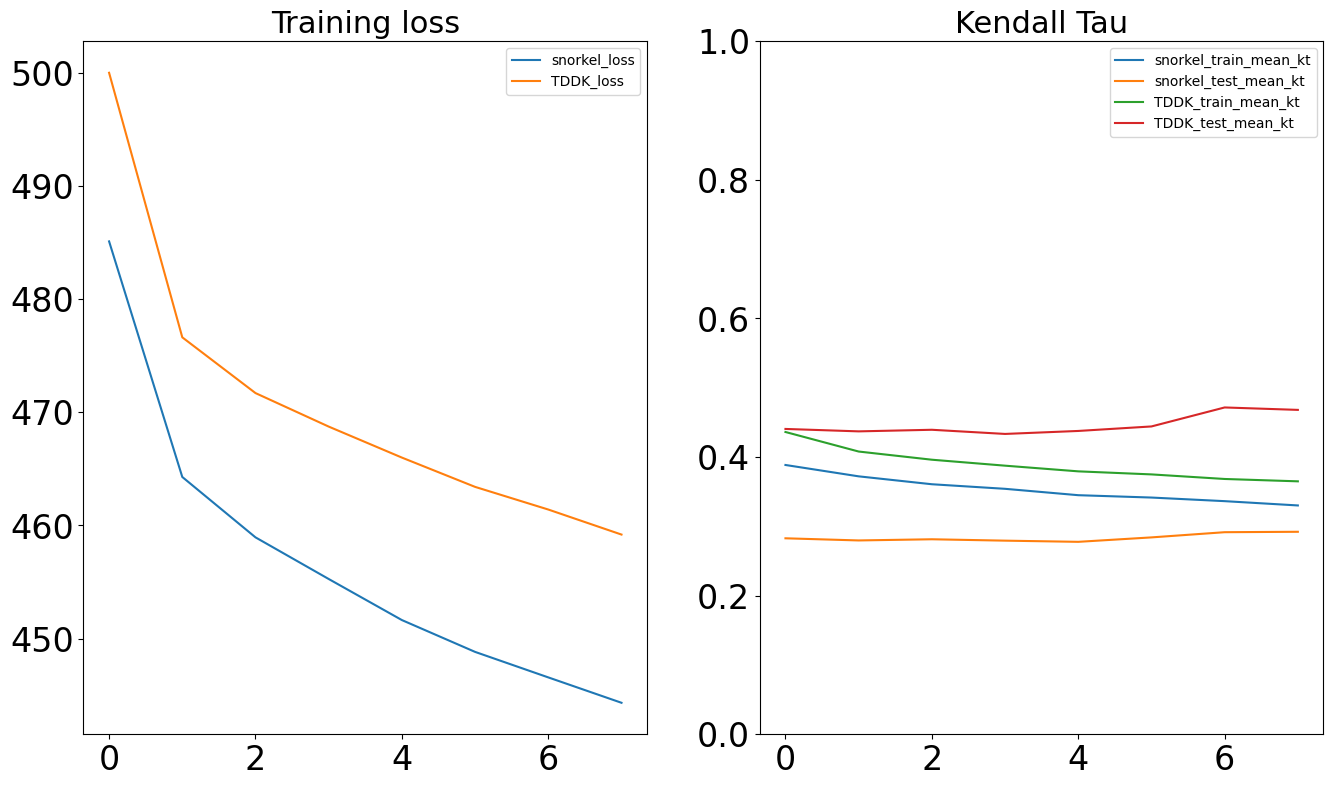

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


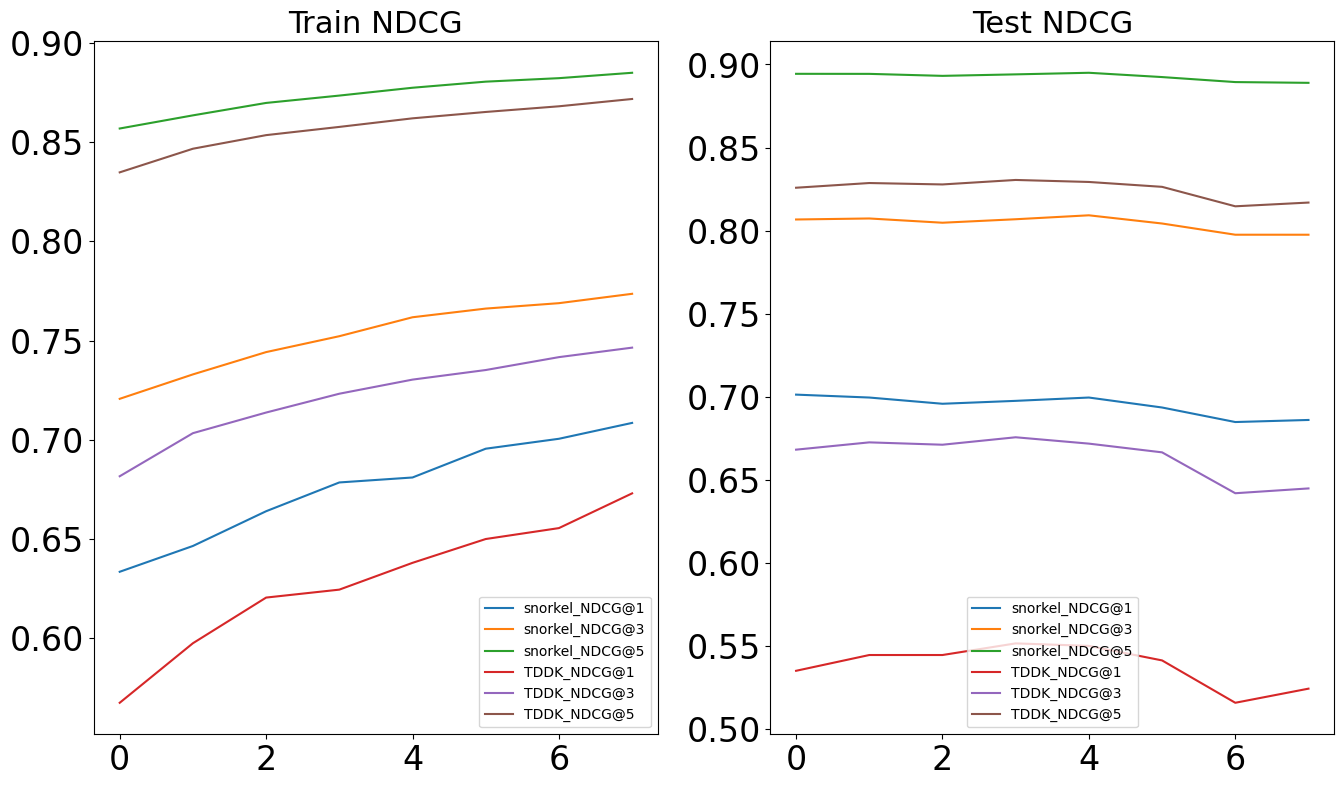

#######################################################################
################### Number of LFs =  4
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.37633333333333335
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'labe

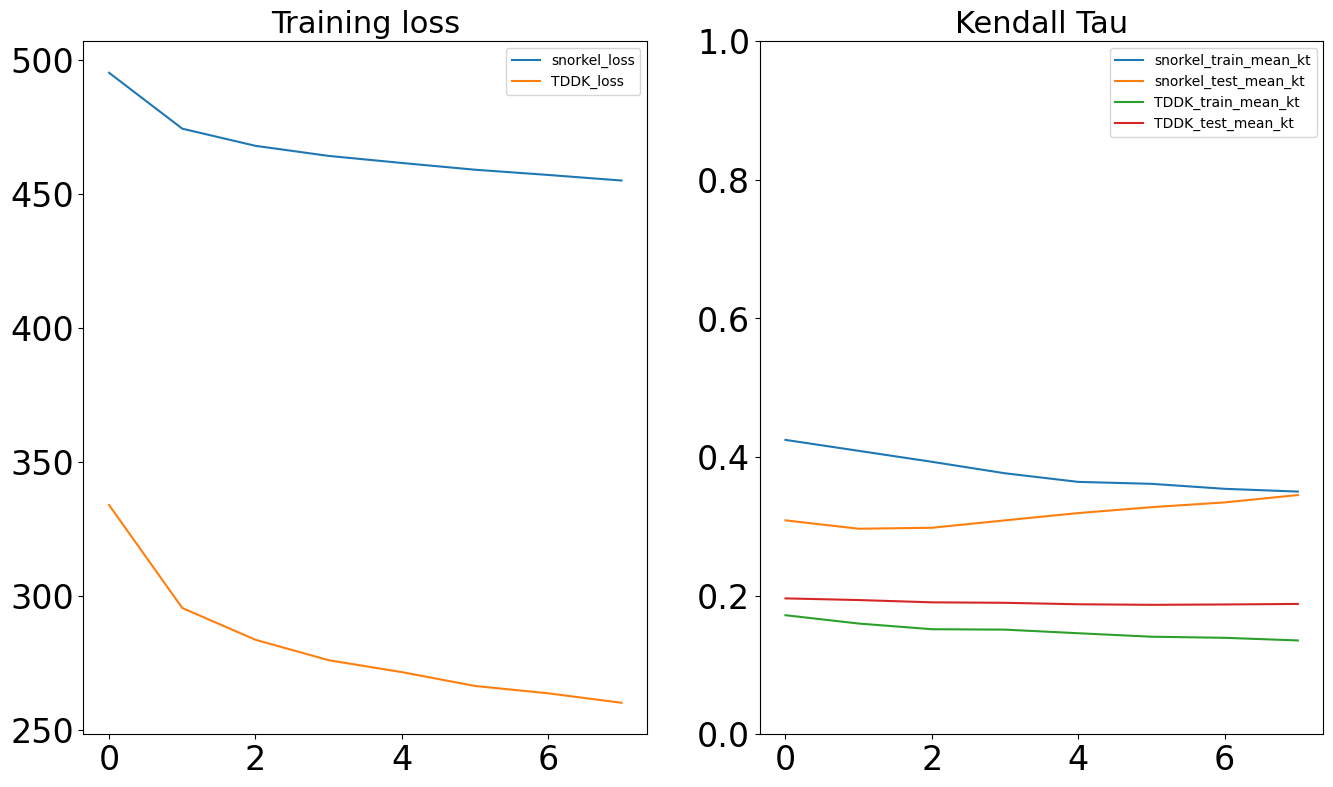

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


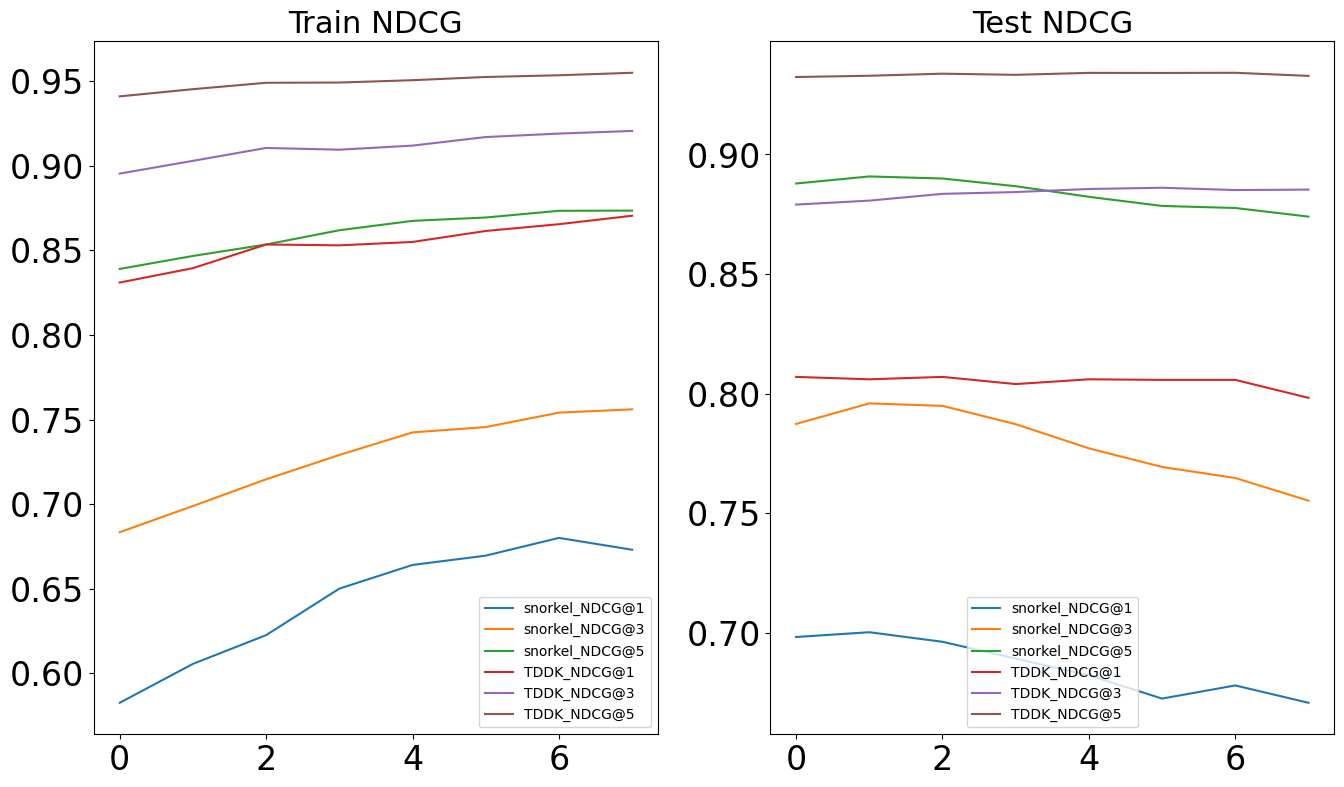

#######################################################################
################### Number of LFs =  5
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.39479999999999993
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'labe

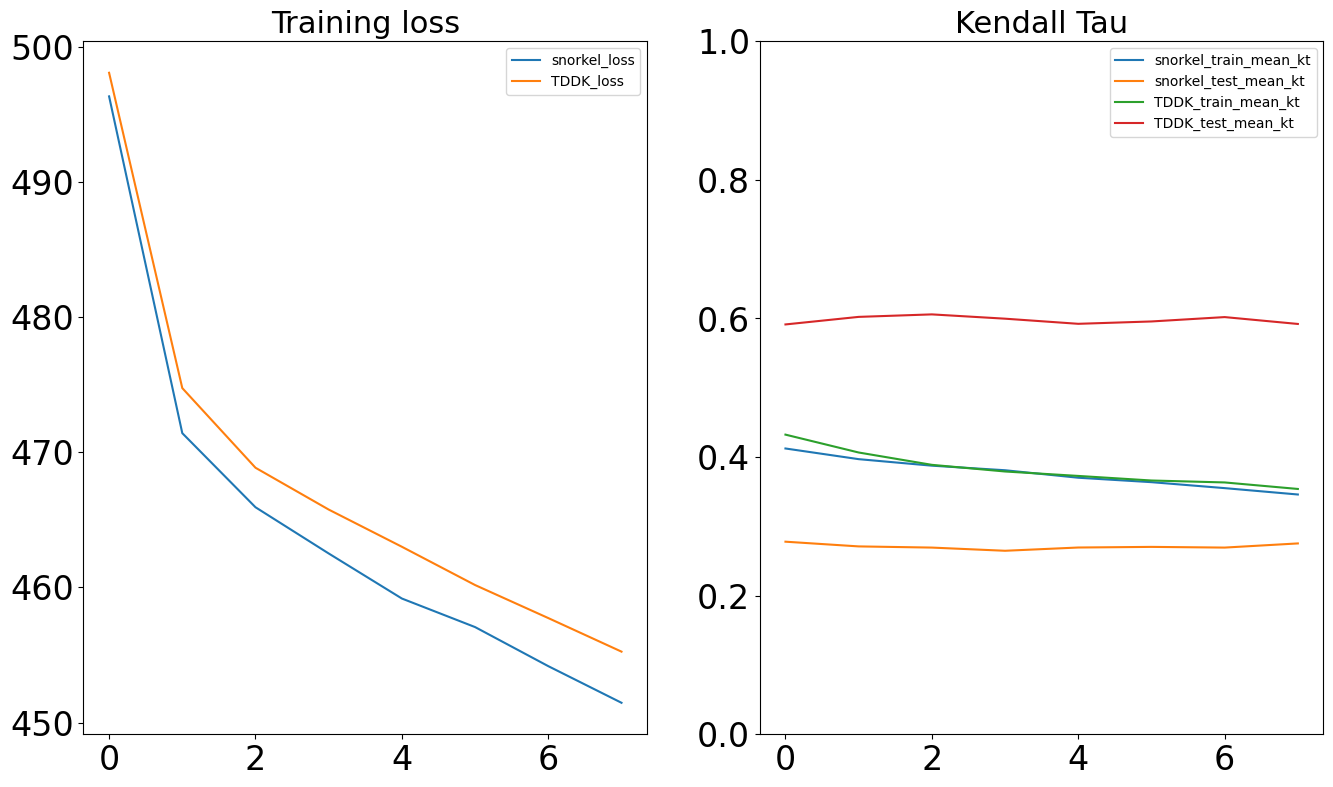

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


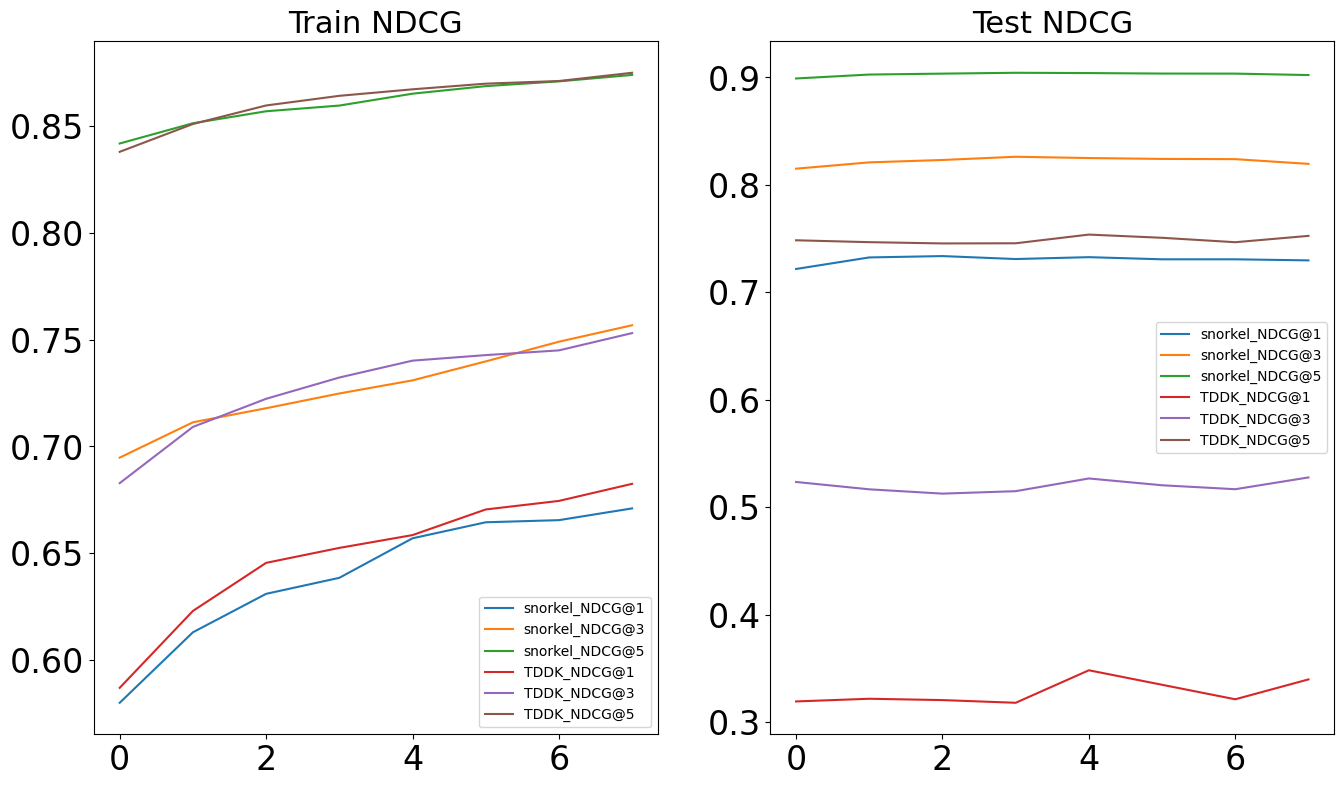

#######################################################################
################### Number of LFs =  6
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.06293333333333334
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'labe

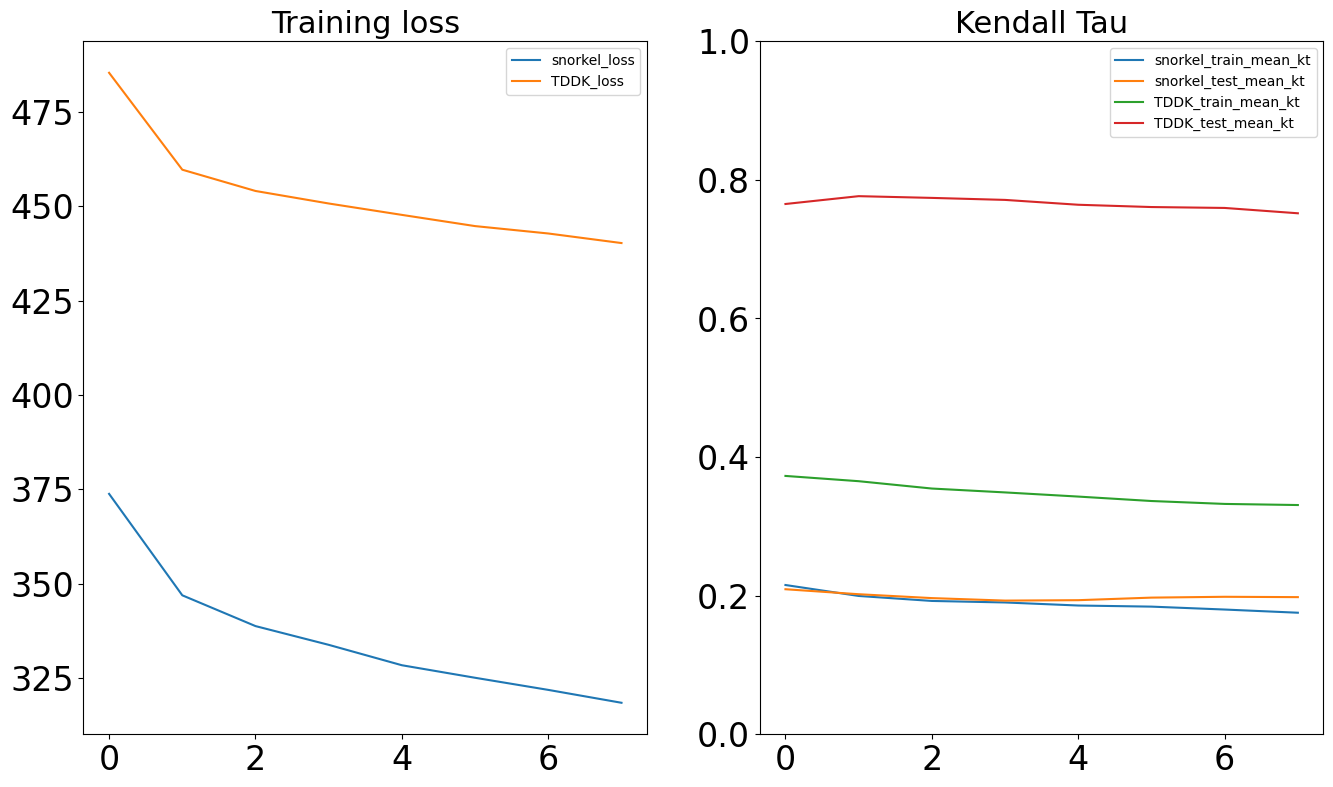

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


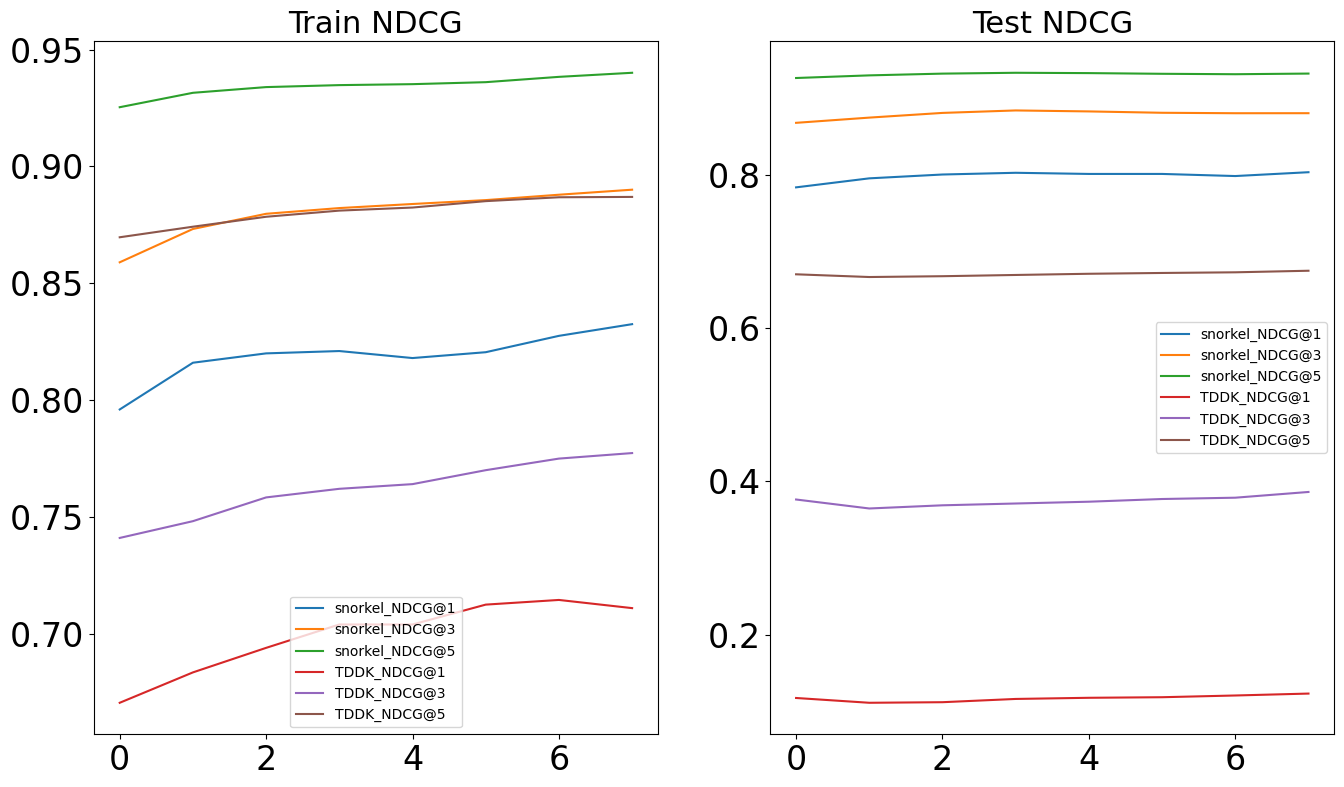

#######################################################################
################### Number of LFs =  7
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.07946666666666667
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'labe

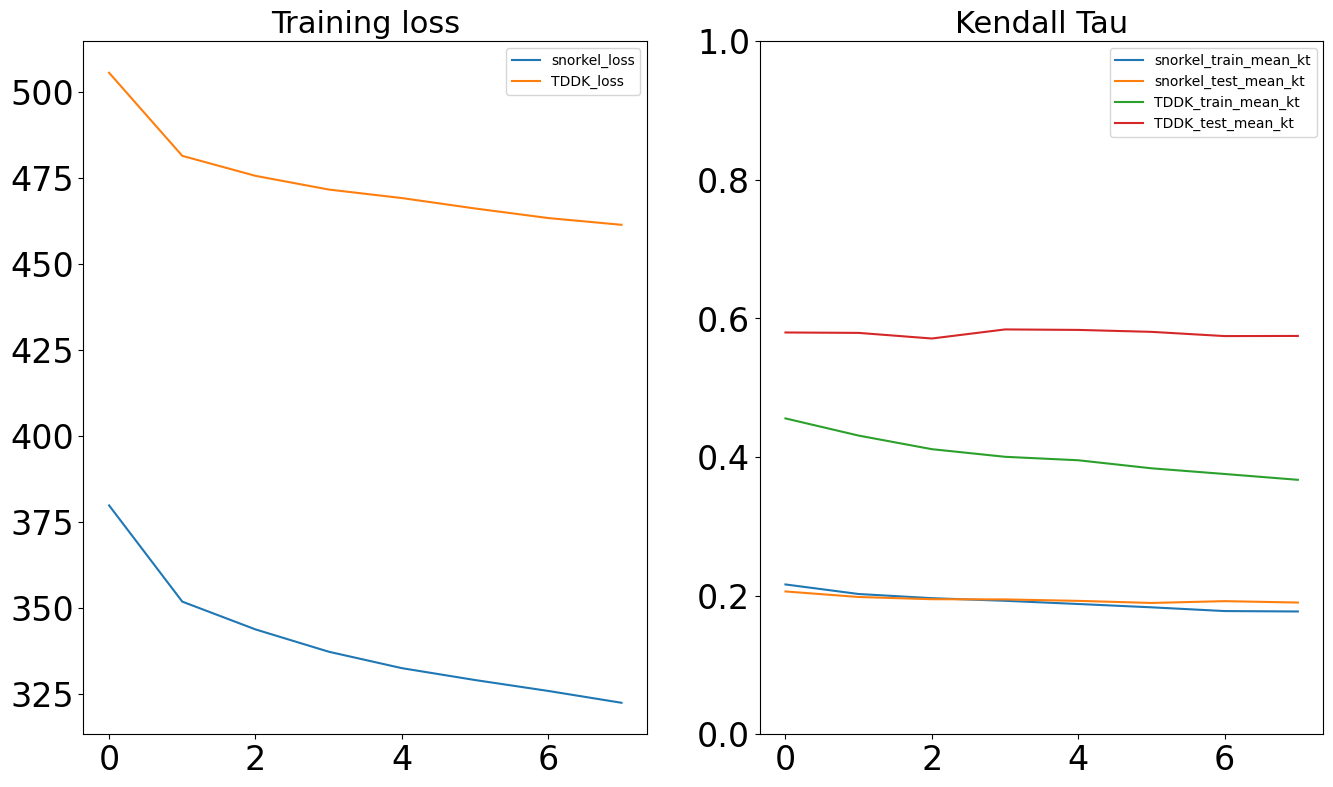

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


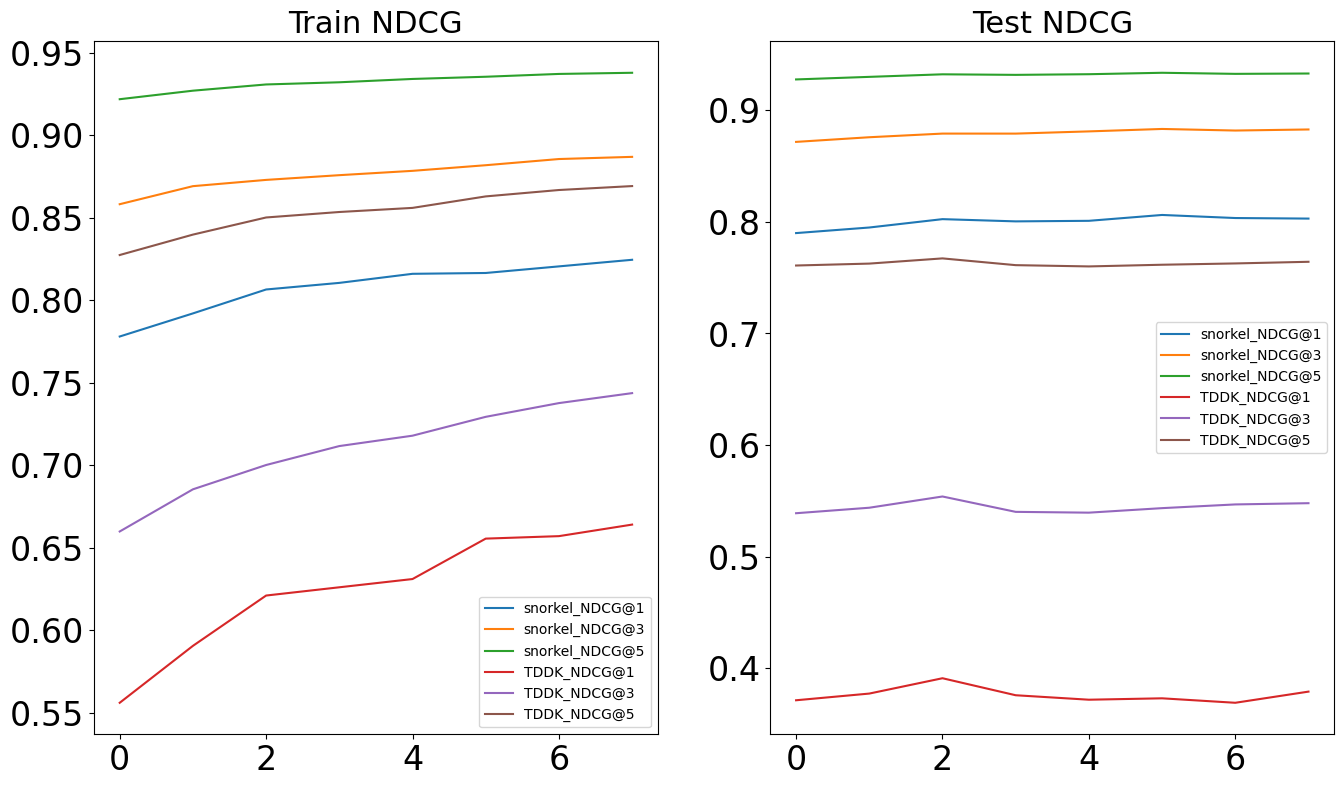

#######################################################################
################### Number of LFs =  8
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.07293333333333334
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'labe

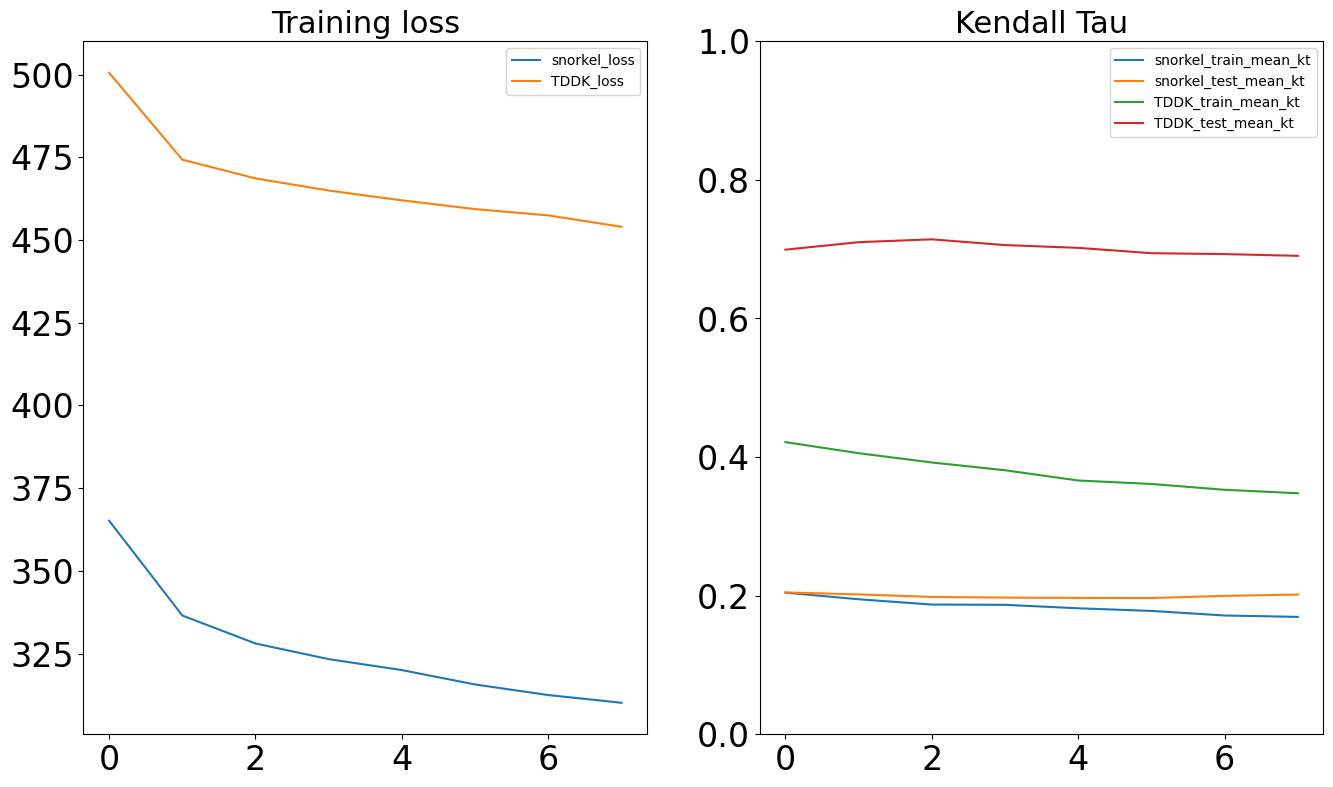

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


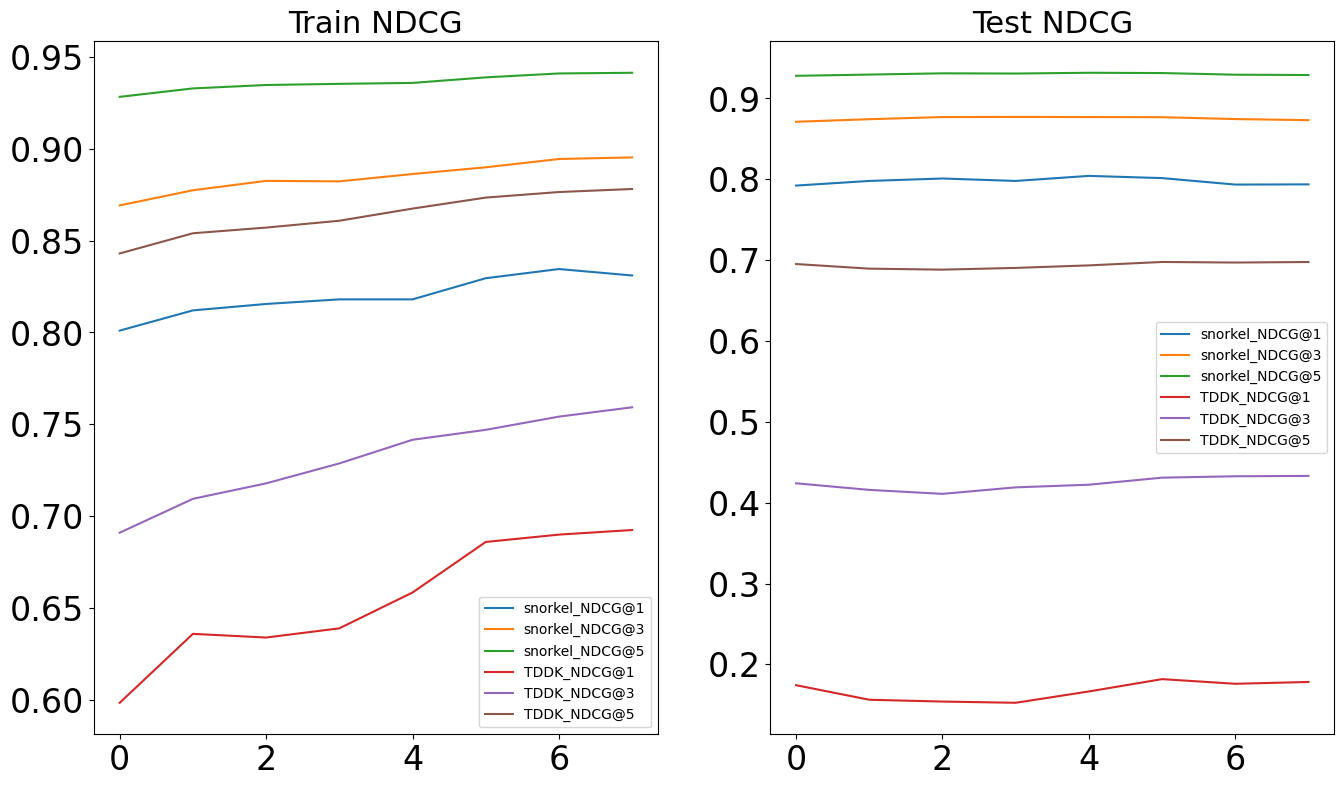

#######################################################################
################### Number of LFs =  9
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.012733333333333334
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'lab

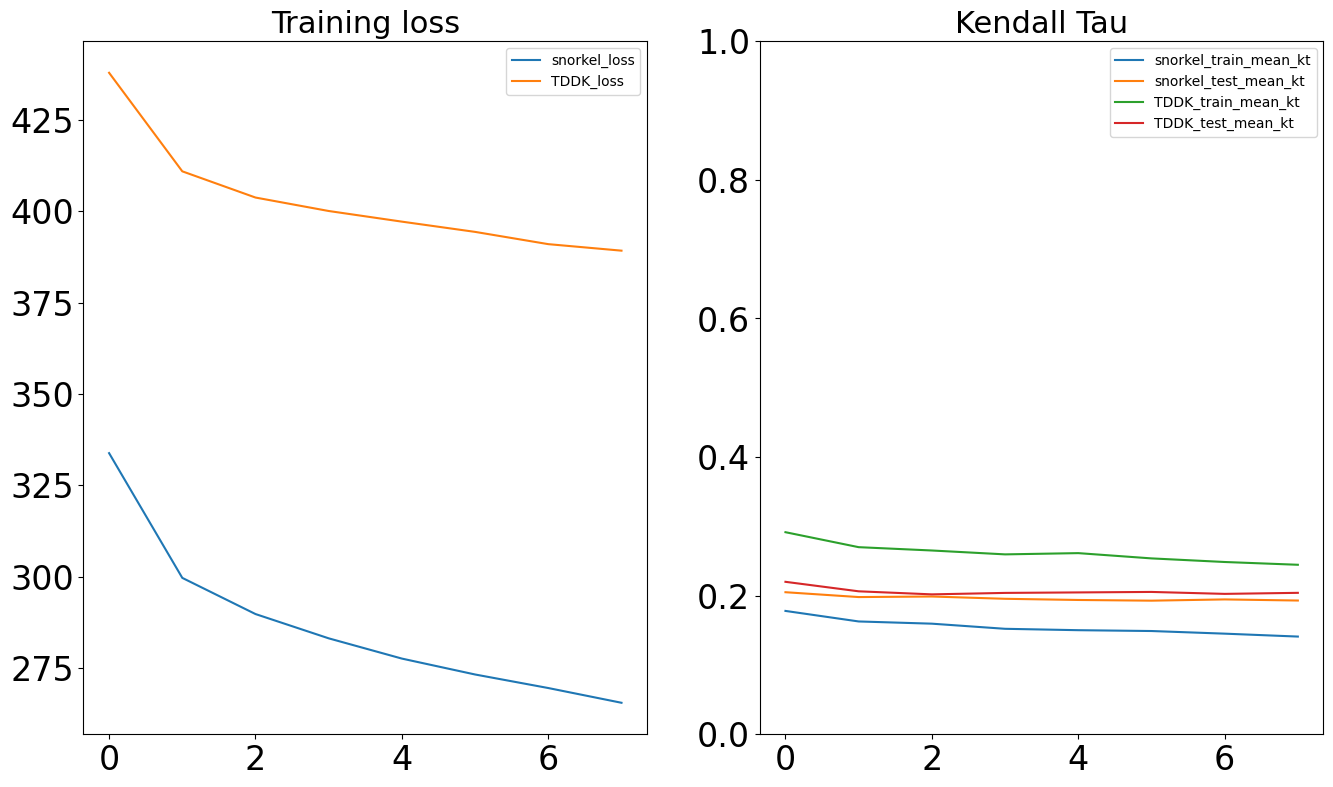

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


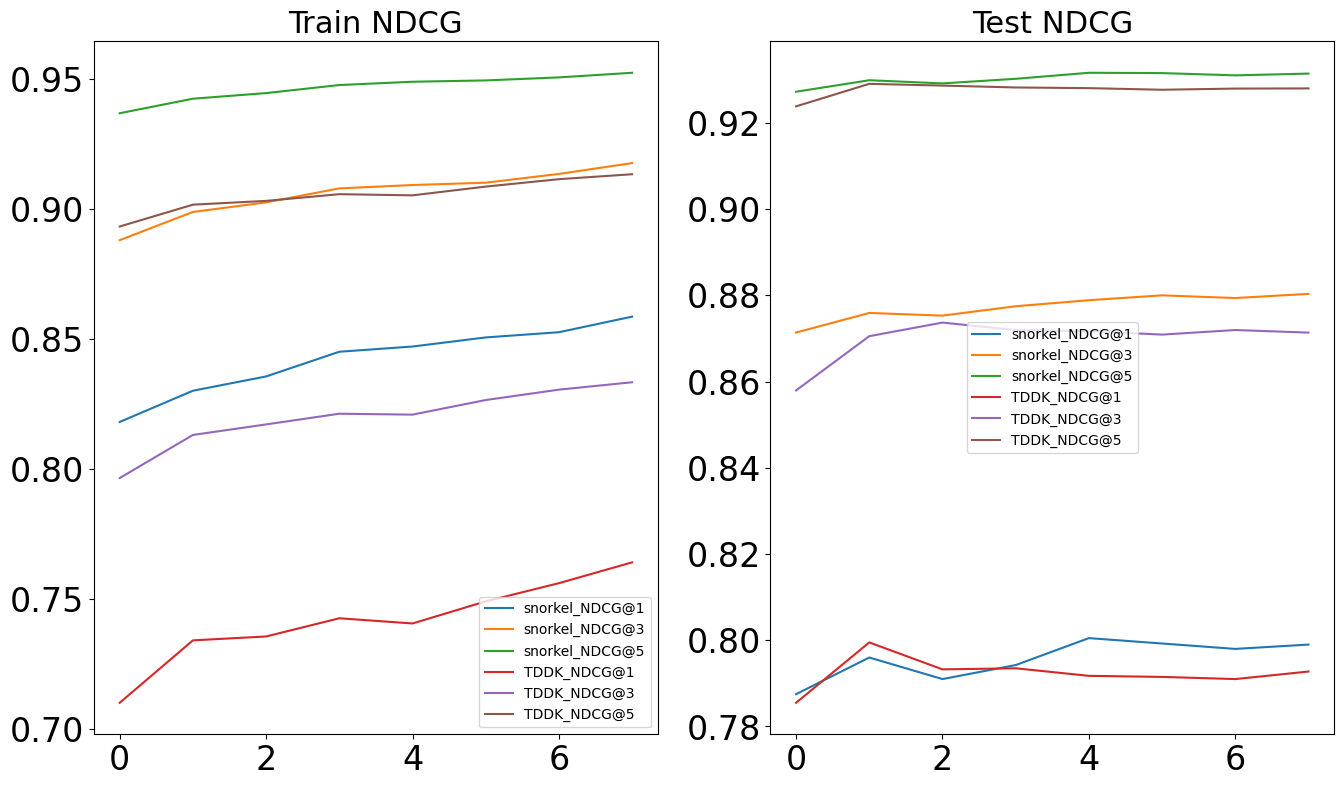

#######################################################################
################### Number of LFs =  10
#######################################################################
Calculating for:  snorkel
Weak labels generated and saved in ../../data/boardgames/processed/default/LFs/synthetic_weak_labels.pkl
Use snorkel...
Label model kt distance:  0.014533333333333334
use_weak_labels:True, we will use weak labels
Training data shape, X_train.shape torch.Size([500, 5, 14]) Y_train.shape torch.Size([500, 5])
set_and_load_data in LTREvaluator
(500, 5, 14) (500, 5) (500,)
data_dict {'data_id': 'boardgames', 'dir_data': 'data/boardgames/processed/default', 'min_docs': 10, 'min_rele': 1, 'scale_data': False, 'scaler_id': None, 'scaler_level': None, 'train_presort': True, 'validation_presort': True, 'test_presort': True, 'train_batch_size': 64, 'validation_batch_size': 1, 'test_batch_size': 64, 'unknown_as_zero': False, 'binary_rele': False, 'num_features': 14, 'has_comment': False, 'la

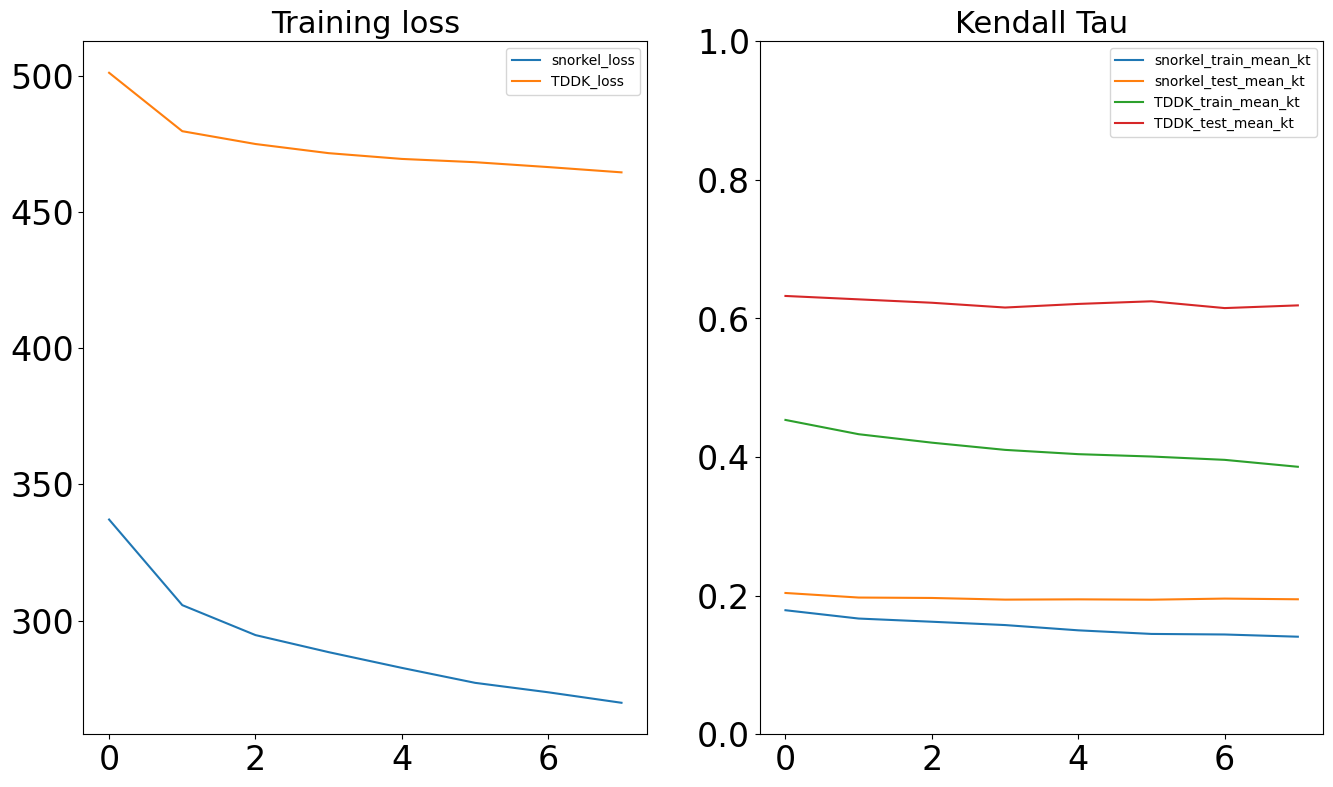

/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


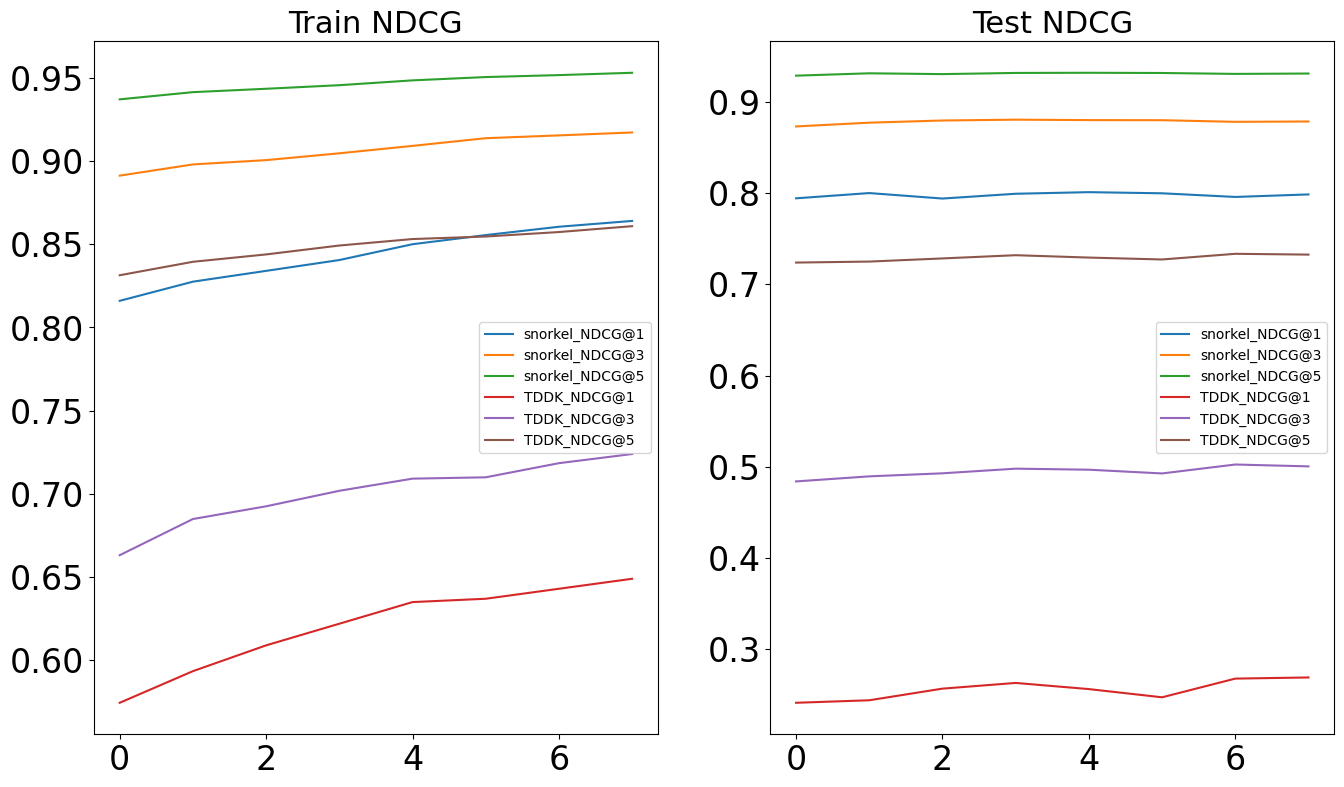

In [12]:
weak_sup_methods = ['snorkel', 'weighted_kemeny_TDDK']
results = {}
Visualize = True

for number_of_LFs in range(3,11):
    
    weak_sup_conf['num_LFs'] = number_of_LFs
    
    print("#######################################################################")
    print("################### Number of LFs = ", number_of_LFs)
    print("#######################################################################")
    
    for weak_sup_method in weak_sup_methods:
        
        weak_sup_conf['inference_rule'] = weak_sup_method
        
        print("Calculating for: ", weak_sup_method)
    
    
        if l2r_training_conf['use_weak_labels']:
            Y_tilde, thetas, individual_kt = get_weak_labels(dataset, weak_sup_conf, root_path=root_path)
            r_utils = RankingUtils(data_conf['dimension'])
            kt = r_utils.mean_kt_distance(Y_tilde,dataset.Y)
            print('Label model kt distance: ', kt)
            dataset.set_Y_tilde(Y_tilde)
        else:
            kt = None


        ptwrapper = PtrankingWrapper(data_conf=data_conf, weak_sup_conf=weak_sup_conf,
                                     l2r_training_conf=l2r_training_conf, result_path=conf['results_path'],
                                     wl_kt_distance = kt)
        X_train, X_test, Y_train, Y_test = dataset.get_train_test_torch(use_weak_labels=l2r_training_conf['use_weak_labels'])
        ptwrapper.set_data(X_train=X_train, X_test=X_test,
                          Y_train=Y_train, Y_test=Y_test)
        model = ptwrapper.get_model()

        results[weak_sup_method] = ptwrapper.train_model(model, verbose=0)
        # TDDK_results = ptwrapper.train_model(model, verbose=1)
        
    if Visualize: 

        plt.rcParams['font.size'] = '24'

        normal_losses = results['snorkel']['loss']
        normal_train_tau = results['snorkel']['train_tau']
        normal_test_tau = results['snorkel']['test_tau']
        normal_train_ndcg1 = results['snorkel']['train_ndcg1']
        normal_train_ndcg3 = results['snorkel']['train_ndcg3']
        normal_train_ndcg5 = results['snorkel']['train_ndcg5']
        normal_test_ndcg1 = results['snorkel']['test_ndcg1']
        normal_test_ndcg3 = results['snorkel']['test_ndcg3']
        normal_test_ndcg5 = results['snorkel']['test_ndcg5']

        TDDK_losses = results['weighted_kemeny_TDDK']['loss']
        TDDK_train_tau = results['weighted_kemeny_TDDK']['train_tau']
        TDDK_test_tau = results['weighted_kemeny_TDDK']['test_tau']
        TDDK_train_ndcg1 = results['weighted_kemeny_TDDK']['train_ndcg1']
        TDDK_train_ndcg3 = results['weighted_kemeny_TDDK']['train_ndcg3']
        TDDK_train_ndcg5 = results['weighted_kemeny_TDDK']['train_ndcg5']
        TDDK_test_ndcg1 = results['weighted_kemeny_TDDK']['test_ndcg1']
        TDDK_test_ndcg3 = results['weighted_kemeny_TDDK']['test_ndcg3']
        TDDK_test_ndcg5 = results['weighted_kemeny_TDDK']['test_ndcg5']


        fig, axes = plt.subplots(ncols=2, figsize=(16,9))
        axes[0].plot(normal_losses, label='snorkel_loss')
        axes[0].set_title(f'Training loss', fontsize=22)
        axes[0].plot(TDDK_losses, label='TDDK_loss')
        axes[0].set_title(f'Training loss', fontsize=22)
        axes[0].legend(fontsize=10)
        axes[1].plot(normal_train_tau, label='snorkel_train_mean_kt')
        axes[1].plot(normal_test_tau, label='snorkel_test_mean_kt')
        axes[1].plot(TDDK_train_tau, label='TDDK_train_mean_kt')
        axes[1].plot(TDDK_test_tau, label='TDDK_test_mean_kt')
        axes[1].set_ylim(0,1)
        axes[1].legend(fontsize=10)
        axes[1].set_title(f'Kendall Tau', fontsize=22)
        plt.show()

        fig, axes = plt.subplots(ncols=2, figsize=(16,9))
        axes[0].plot(normal_train_ndcg1, label='snorkel_NDCG@1')
        axes[0].plot(normal_train_ndcg3, label='snorkel_NDCG@3')
        axes[0].plot(normal_train_ndcg5, label='snorkel_NDCG@5')
        axes[0].plot(TDDK_train_ndcg1, label='TDDK_NDCG@1')
        axes[0].plot(TDDK_train_ndcg3, label='TDDK_NDCG@3')
        axes[0].plot(TDDK_train_ndcg5, label='TDDK_NDCG@5')
        axes[0].legend(fontsize=10)
        axes[0].set_title(f'Train NDCG', fontsize=22)
        axes[1].plot(normal_test_ndcg1, label='snorkel_NDCG@1')
        axes[1].plot(normal_test_ndcg3, label='snorkel_NDCG@3')
        axes[1].plot(normal_test_ndcg5, label='snorkel_NDCG@5')
        axes[1].plot(TDDK_test_ndcg1, label='TDDK_NDCG@1')
        axes[1].plot(TDDK_test_ndcg3, label='TDDK_NDCG@3')
        axes[1].plot(TDDK_test_ndcg5, label='TDDK_NDCG@5')
        axes[1].set_title(f'Test NDCG', fontsize=22)
        axes[1].legend(fontsize=10)
        plt.show()

# Visualizing the Results

In [22]:
file_path = 'final_results.pkl'

with open(file_path, 'rb') as file:
    results = pickle.load(file)

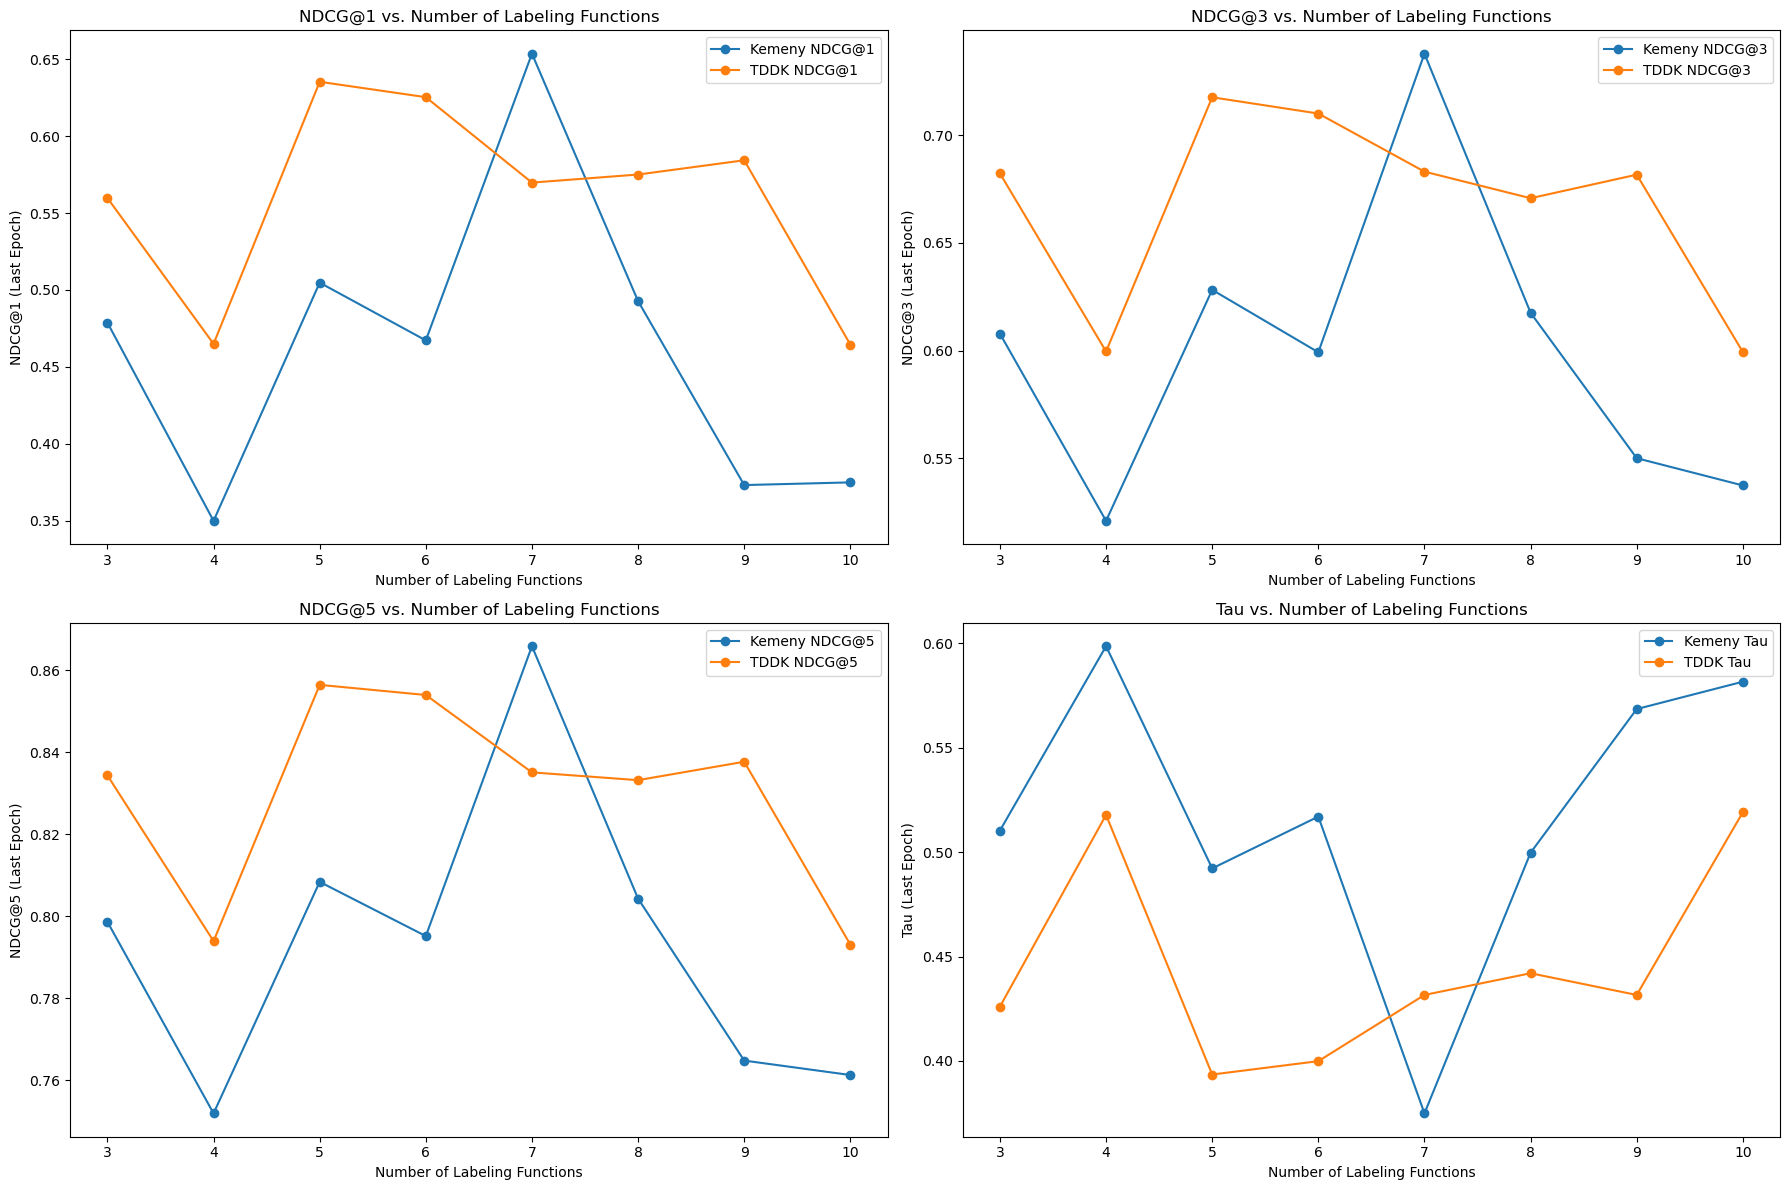

In [23]:
# Initialize lists to store the data for plotting NDCG@1, NDCG@3, NDCG@5, and Taus
num_labeling_functions = []
kemeny_ndcg1 = []
tddk_ndcg1 = []
kemeny_ndcg3 = []
tddk_ndcg3 = []
kemeny_ndcg5 = []
tddk_ndcg5 = []
kemeny_tau = []
tddk_tau = []

# Iterate over the results and extract the last epoch data for all metrics
for num_LFs, data in results.items():
    num_labeling_functions.append(int(num_LFs))
    # Extract last epoch NDCG@1, NDCG@3, NDCG@5, and Tau for weighted_kemeny approach
    kemeny_ndcg1.append(data['weighted_kemeny']['test_ndcg1'][-1].item())
    kemeny_ndcg3.append(data['weighted_kemeny']['test_ndcg3'][-1].item())
    kemeny_ndcg5.append(data['weighted_kemeny']['test_ndcg5'][-1].item())
    kemeny_tau.append(data['weighted_kemeny']['test_tau'][-1][0])

    # Extract last epoch NDCG@1, NDCG@3, NDCG@5, and Tau for TDDK approach
    tddk_ndcg1.append(data['weighted_kemeny_TDDK']['test_ndcg1'][-1].item())
    tddk_ndcg3.append(data['weighted_kemeny_TDDK']['test_ndcg3'][-1].item())
    tddk_ndcg5.append(data['weighted_kemeny_TDDK']['test_ndcg5'][-1].item())
    tddk_tau.append(data['weighted_kemeny_TDDK']['test_tau'][-1][0])

# Plotting all the accuracies and taus
plt.figure(figsize=(18, 12))

# NDCG@1 plot
plt.subplot(2, 2, 1)
plt.plot(num_labeling_functions, kemeny_ndcg1, label='Kemeny NDCG@1', marker='o')
plt.plot(num_labeling_functions, tddk_ndcg1, label='TDDK NDCG@1', marker='o')
plt.xlabel('Number of Labeling Functions')
plt.ylabel('NDCG@1 (Last Epoch)')
plt.title('NDCG@1 vs. Number of Labeling Functions')
plt.legend()

# NDCG@3 plot
plt.subplot(2, 2, 2)
plt.plot(num_labeling_functions, kemeny_ndcg3, label='Kemeny NDCG@3', marker='o')
plt.plot(num_labeling_functions, tddk_ndcg3, label='TDDK NDCG@3', marker='o')
plt.xlabel('Number of Labeling Functions')
plt.ylabel('NDCG@3 (Last Epoch)')
plt.title('NDCG@3 vs. Number of Labeling Functions')
plt.legend()

# NDCG@5 plot
plt.subplot(2, 2, 3)
plt.plot(num_labeling_functions, kemeny_ndcg5, label='Kemeny NDCG@5', marker='o')
plt.plot(num_labeling_functions, tddk_ndcg5, label='TDDK NDCG@5', marker='o')
plt.xlabel('Number of Labeling Functions')
plt.ylabel('NDCG@5 (Last Epoch)')
plt.title('NDCG@5 vs. Number of Labeling Functions')
plt.legend()

# Tau plot
plt.subplot(2, 2, 4)
plt.plot(num_labeling_functions, kemeny_tau, label='Kemeny Tau', marker='o')
plt.plot(num_labeling_functions, tddk_tau, label='TDDK Tau', marker='o')
plt.xlabel('Number of Labeling Functions')
plt.ylabel('Tau (Last Epoch)')
plt.title('Tau vs. Number of Labeling Functions')
plt.legend()

plt.tight_layout()
plt.show()